In [33]:
MKT_BOOK = {}

In [3]:
import pandas as pd
import numpy as np
import os
print(os.environ['IEX_TOKEN'])
pd.options.display.float_format = '{:,.2f}'.format

SYM_LIST = ['GOOGL', 'FB', 'TWTR', 'VRSN', 'AKAM', 'TRIP', 'MSFT', 'ADP', 'CTXS', 'IRM', 'FFIV',
           'JPM', 'BAC', 'WFC', 'C', 'PNC', 'CMA', 'PYPL', 'MA', 'V', 'AXP', 'COF', 'DFS', 'SYF',
           'EFX', 'WU', 'NAVI', 'ORCL', 'ADBE', 'CRM', 'INTU', 'ANSS', 'CDNS',
           'WMT', 'COST', 'TGT', 'DG', 'DLTR',
           'DIS', 'CMCSA', 'FOXA']

pk_2f841cbff2d6422ab0145ada59fa5d34


In [34]:
# Finance data time
from datetime import datetime
from iexfinance.stocks import get_historical_data

for sym in SYM_LIST:
    if sym not in MKT_BOOK:
        start = datetime(2019, 1, 1)
        end = datetime(2019, 12, 31)
        print("Retrieving {}".format(sym))
        MKT_BOOK[sym] = pd.DataFrame(get_historical_data(sym, start, end)).transpose()
    else:
        print('{} already retrieved'.format(sym))

Retrieving GOOGL
Retrieving FB
Retrieving TWTR
Retrieving VRSN
Retrieving AKAM
Retrieving TRIP
Retrieving MSFT
Retrieving ADP
Retrieving CTXS
Retrieving IRM
Retrieving FFIV
Retrieving JPM
Retrieving BAC
Retrieving WFC
Retrieving C
Retrieving PNC
Retrieving CMA
Retrieving PYPL
Retrieving MA
Retrieving V
Retrieving AXP
Retrieving COF
Retrieving DFS
Retrieving SYF
Retrieving EFX
Retrieving WU
Retrieving NAVI
Retrieving ORCL
Retrieving ADBE
Retrieving CRM
Retrieving INTU
Retrieving ANSS
Retrieving CDNS
Retrieving WMT
Retrieving COST
Retrieving TGT
Retrieving DG
Retrieving DLTR
Retrieving DIS
Retrieving CMCSA
Retrieving FOXA


In [5]:
def pos_streaker(x):
    global count
    if(x > 0):
        count += 1
    else:
        count = 0
    return count

In [6]:
def neg_streaker(x):
    global count
    if(x <= 0):
        count += 1
    else:
        count = 0
    return count

In [7]:
def strat_builder(x):
    if x['volume'] < (x['vol_mean'] - x['vol_std']) and x['dow'] == 'Friday':
        return -1
    elif x['volume'] > (x['vol_mean'] + x['vol_std']) and x['dow'] != 'Friday':
        return 1
    else:
        return 0
    
    

In [45]:
def ten_twenty_avg(x):
    if (x['10_avg'] > x['20_avg']):
        return 1
    else:
        return -1

In [9]:
def dow_strat_builder(x): # Winner so far
    if x['dow'] == 'Friday': # Short on Friday Close
        return -1
    elif x['dow'] == 'Monday': # Long Monday Open
        return 1
    else:
        return 0

In [10]:
corr_frame = pd.DataFrame()

In [23]:
one_per_return_corr = pd.DataFrame()
corr_list = []
for sym in MKT_BOOK:
    one_per_return_corr[sym] = MKT_BOOK[sym].shift(3)['log_returns'] # One day shift correlation between closing prices
one_per_return_corr = one_per_return_corr.corr() 
one_per_return_corr = one_per_return_corr[one_per_return_corr > 0.9]
one_per_return_corr = one_per_return_corr[one_per_return_corr < 1]
one_per_return_corr[:5]
for col in one_per_return_corr:
    for idx, val in one_per_return_corr[col].iteritems():
        if not pd.isna(val):
            print("One period shifted Corr between {} and {} is {}".format(col, idx, val))
            # append col and idx as tuples to pull out into a strat corr_list.append()
            

One period shifted Corr between BAC and C is 0.9221443081467452
One period shifted Corr between C and BAC is 0.9221443081467452
One period shifted Corr between DFS and SYF is 0.9555942903751679
One period shifted Corr between SYF and DFS is 0.9555942903751679


In [24]:
# TODO strat based on above
# If DFS log returns > 0 1 else -1

In [46]:
for sym in SYM_LIST:
    df = MKT_BOOK[sym]
    df['log_returns'] = np.log(df['close']/df['close'].shift(1))
    df['vol_mean'] = df['volume'].mean()
    df['vol_std']= df['volume'].std()
    day_series = pd.date_range(start, end, freq='D').to_series()
    day_series_dow = day_series.dt.dayofweek
    df['volume_direction'] = np.where(df['volume'] > df['volume'].shift(1), 1, -1)
    df['10_avg'] = df['close'].rolling(10).mean()
    df['20_avg'] = df['close'].rolling(20).mean()
    df['date'] = df.index
    count = 0 
    df['up_streaks'] = df['log_returns'].apply(pos_streaker)
    df['down_streaks'] = df['log_returns'].apply(neg_streaker)
    df['dow'] = pd.to_datetime(df['date'], errors='coerce').dt.day_name()
    df['price_mean'] = df['close'].mean()
    df['price_std'] = df['close'].std()
    df['std_dist'] = ((df['close'] - df['price_mean']) / df['price_std'])
    
    df['dist_ovr_two_sig'] = np.where(abs(df['std_dist']) > 1, 1, 0) # expand this to a a strat to apply       
    df['strat'] = df.apply(ten_twenty_avg, axis=1)
    # To do return strategy from that
    df['passive_returns'] = np.cumsum(df['log_returns'])
    # Shift a day forward - if a strat initiates at the close, it captures the next close-close log returns
    df['strat_returns'] = np.cumsum(df['strat'] * df.shift(-1, fill_value=0)['log_returns'])
    df['two_sig_returns'] = np.cumsum(df['dist_ovr_two_sig'] * df.shift(-1, fill_value=0)['log_returns'])

In [47]:
MKT_BOOK['MSFT'][-1:]

,close,high,low,open,volume,log_returns,vol_mean,vol_std,volume_direction,10_avg,...,down_streaks,dow,price_mean,price_std,std_dist,dist_ovr_two_sig,strat,passive_returns,strat_returns,two_sig_returns
2019-12-31,157.70,157.77,156.45,156.77,"18,393,383.00",0.00,"24,673,844.01","7,699,540.45",1,156.99,...,0,Tuesday,130.38,14.90,1.83,1,1,0.44,0.18,0.21


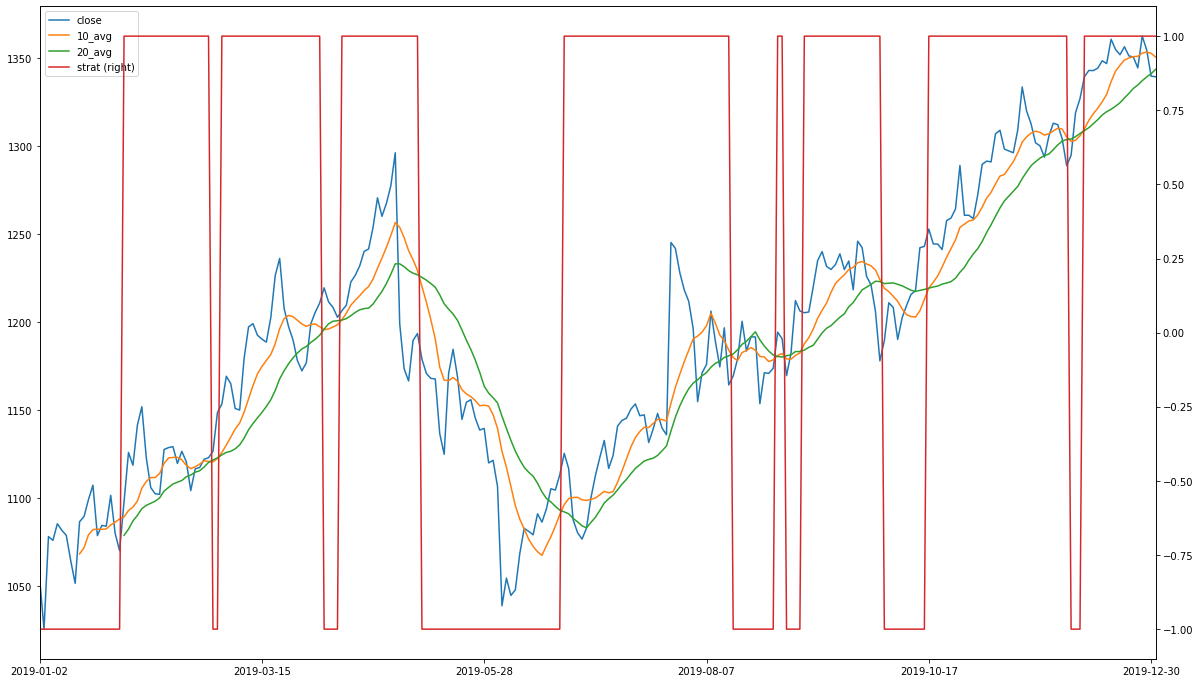

In [55]:
MKT_BOOK['GOOGL'][['close', '10_avg', '20_avg', 'strat']].plot(figsize=(20,12), secondary_y='strat')

In [60]:
def plot_strat(sym):    
    strat_plot = pd.DataFrame([MKT_BOOK[sym]['strat_returns'], MKT_BOOK[sym]['passive_returns']])
    strat_plot = strat_plot.transpose()
    strat_plot.plot(figsize=(20,12))

In [59]:
INITIAL_BET = 10000
PORTFOLIO_PROFIT = 0
STARTING_CAPITAL = len(SYM_LIST * INITIAL_BET)
returns = []
for sym in SYM_LIST:
    PORTFOLIO_PROFIT += ((MKT_BOOK[sym][-1:]['strat_returns'] + 1) * INITIAL_BET) - INITIAL_BET # etc.
print("Returns Per Instrument\n=================================")
for sym in SYM_LIST:
    print("{} : {}".format(sym, (MKT_BOOK[sym][-1:]['strat_returns'].to_string(index=False))))
print("Starting Capital: {}".format(STARTING_CAPITAL))
print("Profit/Loss: {}".format(PORTFOLIO_PROFIT))
print("P/L %: {}".format((STARTING_CAPITAL + PORTFOLIO_PROFIT) / STARTING_CAPITAL - 1))

Returns Per Instrument
GOOGL : -0.05
FB : -0.06
TWTR : 0.26
VRSN : 0.30
AKAM : -0.05
TRIP : -0.39
MSFT : 0.18
ADP : -0.24
CTXS : 0.20
IRM : -0.44
FFIV : -0.15
JPM : -0.11
BAC : -0.11
WFC : -0.27
C : -0.37
PNC : -0.07
CMA : 0.05
PYPL : -0.02
MA : 0.14
V : 0.09
AXP : 0.03
COF : -0.29
DFS : -0.03
SYF : -0.23
EFX : -0.09
WU : 0.12
NAVI : -0.42
ORCL : 0.04
ADBE : 0.25
CRM : -0.47
INTU : -0.21
ANSS : 0.07
CDNS : 0.20
WMT : -0.10
COST : -0.08
TGT : -0.25
DG : -0.03
DLTR : 0.25
DIS : 0.23
CMCSA : 0.03
FOXA : -0.01
Starting Capital: 410000
Profit/Loss: 2019-12-31   -21,081.95
Name: strat_returns, dtype: float64
P/L %: 2019-12-31   -0.05
Name: strat_returns, dtype: float64


In [51]:
# Consider regime switching for what strat to run

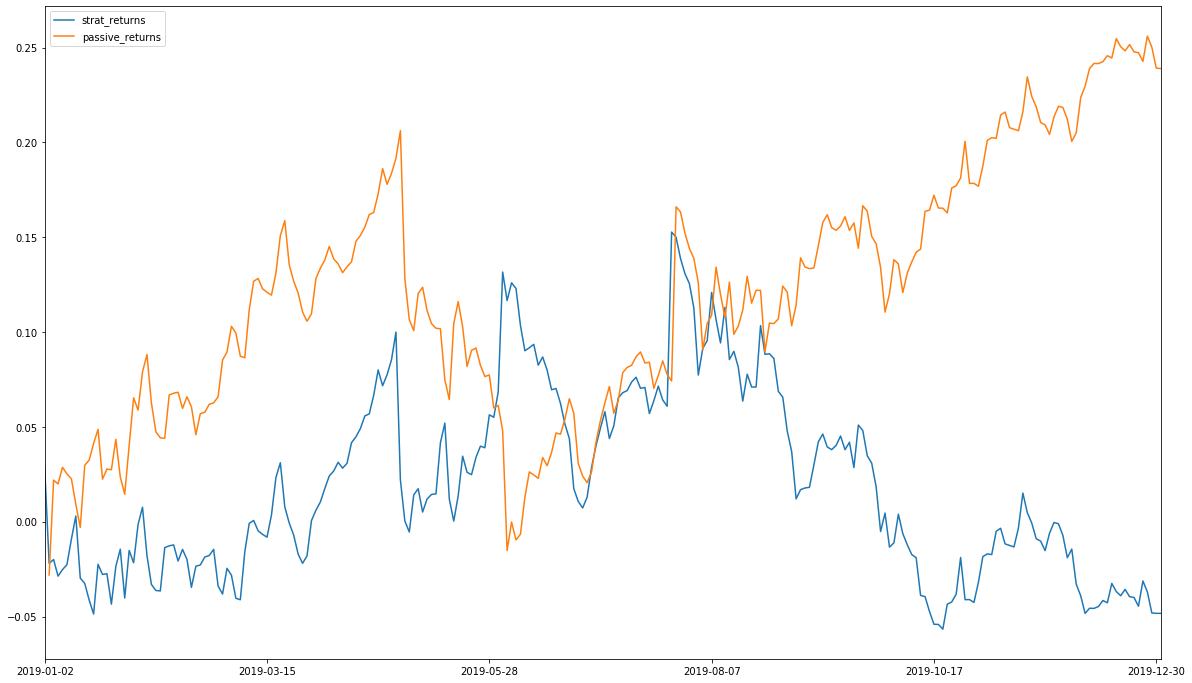

In [61]:
plot_strat('GOOGL')

In [ ]:
# Learn how to group volume by day.
# What's emerging is a vector of variables.

In [62]:
# Strat to implement - buy at close, sell at open
# Strat to implement - more than one std_dev above regression line